In [4]:
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
sns.set_style('darkgrid')
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
path    = 'data/'  # If data in 'data' directory
delian = pd.read_excel(path + 'DeLiAn_edited.xlsx', sheet_name=None)
# Now delian is a dictionary where each key is the sheet name
# and each value is the corresponding DataFrame

In [6]:
for sheet_name, df in delian.items():
    print(f"Sheet Name: {sheet_name}")
    print(df.head())
    print("----------------------------------------------------------------")

Sheet Name: List of variables
   Sheet                            Variables (unit)  \
0      1   angstrom_exponent_backscatter_355_532 (1)   
1      2  angstrom_exponent_backscatter_532_1064 (1)   
2      3    angstrom_exponent_extinction_355_532 (1)   
3      4                                 campaign_rv   
4      5                                        date   

                                         Description  
0  Angstrom exponent at 355/532 nm backscatter-re...  
1  Angstrom exponent at 532/1064 nm backscatter-r...  
2  Angstrom exponent at 355/532 nm extinction-rel...  
3     Name of the campaign or of the research vessel  
4  Date of the lidar observations (DD-MM-YYYY or ...  
----------------------------------------------------------------
Sheet Name: 1
       Ash  Saharan dust  Central Asian dust  Middle Eastern dust   Smoke  \
0 -9999.00       -9999.0           -0.061045              -9999.0 -9999.0   
1 -9999.00       -9999.0           -0.418634                  0.6 -999

In [7]:
variable_names = delian['List of variables']
# Iterate through each sheet and rename them
for sheet_name in delian.keys():
    if sheet_name != 'List of variables':
        # Filter the rows based on the condition and selecting the 'Variables (unit)' column
        new_sheet_name = variable_names.loc[variable_names['Sheet'] == int(sheet_name), 'Variables (unit)'].values[0]
        delian[new_sheet_name] = delian.pop(sheet_name)
        
delian.keys()

dict_keys(['List of variables', 'angstrom_exponent_backscatter_355_532 (1)', 'error_angstrom_exponent_backscatter_355_532 (1)', 'angstrom_exponent_backscatter_532_1064 (1)', 'error_angstrom_exponent_backscatter_532_1064 (1)', 'angstrom_exponent_extinction_355_532 (1)', 'error_angstrom_exponent_extinction_355_532 (1)', 'lidar_ratio_355 (sr)', 'error_lidar_ratio_355 (sr)', 'lidar_ratio_532 (sr)', 'error_lidar_ratio_532 (sr)', 'particle_linear_depolarization_ratio_355 (%)', 'error_particle_linear_depolarization_ratio_355 (%)', 'particle_linear_depolarization_ratio_532 (%)', 'error_particle_linear_depolarization_ratio_532 (%)', 'number_samples (1)', 'campaign_rv', 'date', 'location', 'measurement_type', 'reference', 'system'])

### **Data Preprocessing**

In [8]:
samples = delian['number_samples (1)']
samples

,Ash,Saharan dust,Central Asian dust,Middle Eastern dust,Smoke,Stratospheric smoke,Dust and smoke,Pollution,Dust and pollution,Dried marine,Clean marine,Dust and marine,Central European background
0,4,30,23,4,71,8,25,42,15,7,52,21,14


In [9]:
#Define a new df containing the label (type of aerosol) of all observations
aerosol = []
for col in samples.columns:
  for i in range(int(samples[col].iloc[0])):
    aerosol.append(col)
aerosol = pd.DataFrame({"aerosol": aerosol})
aerosol['aerosol'] = aerosol['aerosol'].astype('category') #convert type from Object to Categorical
aerosol

,aerosol
0,Ash
1,Ash
2,Ash
3,Ash
4,Saharan dust
...,...
311,Central European background
312,Central European background
313,Central European background
314,Central European background


In [10]:
# Sheets to be interessed
quantitatives = [
    'angstrom_exponent_backscatter_355_532 (1)',
    'error_angstrom_exponent_backscatter_355_532 (1)',
    'angstrom_exponent_backscatter_532_1064 (1)',
    'error_angstrom_exponent_backscatter_532_1064 (1)',
    'angstrom_exponent_extinction_355_532 (1)',
    'error_angstrom_exponent_extinction_355_532 (1)',
    'lidar_ratio_355 (sr)',
    'error_lidar_ratio_355 (sr)',
    'lidar_ratio_532 (sr)',
    'error_lidar_ratio_532 (sr)',
    'particle_linear_depolarization_ratio_355 (%)',
    'error_particle_linear_depolarization_ratio_355 (%)',
    'particle_linear_depolarization_ratio_532 (%)',
    'error_particle_linear_depolarization_ratio_532 (%)'
]
delian1 = {key: delian[key] for key in quantitatives}

In [11]:
properties = [
    'angstrom_exponent_backscatter_355_532 (1)',
    'angstrom_exponent_backscatter_532_1064 (1)',
    'angstrom_exponent_extinction_355_532 (1)',
    'lidar_ratio_355 (sr)',
    'lidar_ratio_532 (sr)',
    'particle_linear_depolarization_ratio_355 (%)',
    'particle_linear_depolarization_ratio_532 (%)',
]
delian2 = {key: delian[key] for key in properties}

In [12]:
# Convert each sheet to a column as variable
delian_df = pd.DataFrame()

# Iterate through each sheet and extract information
for sheet_name, df in delian1.items():
  new_values = []
  for col in df.columns:
    for value in df[col]:
      # Check if the value is not NaN
      if pd.notna(value):
        new_values.append(value)
  new_df = pd.DataFrame({sheet_name: new_values})
  delian_df = pd.concat([delian_df, new_df], axis=1)

delian_df = pd.concat([delian_df, aerosol], axis=1)
delian_df

,angstrom_exponent_backscatter_355_532 (1),error_angstrom_exponent_backscatter_355_532 (1),angstrom_exponent_backscatter_532_1064 (1),error_angstrom_exponent_backscatter_532_1064 (1),angstrom_exponent_extinction_355_532 (1),error_angstrom_exponent_extinction_355_532 (1),lidar_ratio_355 (sr),error_lidar_ratio_355 (sr),lidar_ratio_532 (sr),error_lidar_ratio_532 (sr),particle_linear_depolarization_ratio_355 (%),error_particle_linear_depolarization_ratio_355 (%),particle_linear_depolarization_ratio_532 (%),error_particle_linear_depolarization_ratio_532 (%),aerosol
0,-9999.00,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00,55.00,5.00,-9999.0,-9999.0,36.50,1.0,-9999.0,-9999.0,Ash
1,-9999.00,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00,55.00,5.00,-9999.0,-9999.0,37.50,2.0,-9999.0,-9999.0,Ash
2,0.22,0.4,1.05,0.43,0.68,0.63,39.00,10.00,32.0,4.0,-9999.00,-9999.0,-9999.0,-9999.0,Ash
3,1.00,-9999.0,1.00,-9999.00,1.00,-9999.00,55.00,10.00,64.0,11.0,34.00,4.0,-9999.0,-9999.0,Ash
4,-9999.00,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00,63.00,9.00,-9999.0,-9999.0,24.00,2.0,31.0,1.0,Saharan dust
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,-9999.00,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00,48.07,2.24,-9999.0,-9999.0,2.91,2.0,-9999.0,-9999.0,Central European background
312,-9999.00,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00,58.02,7.59,-9999.0,-9999.0,3.76,2.0,-9999.0,-9999.0,Central European background
313,-9999.00,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00,58.57,5.69,-9999.0,-9999.0,3.75,2.0,-9999.0,-9999.0,Central European background
314,-9999.00,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00,60.56,3.41,-9999.0,-9999.0,3.91,2.0,-9999.0,-9999.0,Central European background


### **Data Imputation**

In [61]:
def mean_without_9999(column):
    mean = column[column != -9999.].mean()
    return mean

def replace_9999(column):
    mean = mean_without_9999(column)
    column[column == -9999.] = mean
    return column

df = delian_df.groupby('aerosol', observed=True).transform(replace_9999)

df

,angstrom_exponent_backscatter_355_532 (1),error_angstrom_exponent_backscatter_355_532 (1),angstrom_exponent_backscatter_532_1064 (1),error_angstrom_exponent_backscatter_532_1064 (1),angstrom_exponent_extinction_355_532 (1),error_angstrom_exponent_extinction_355_532 (1),lidar_ratio_355 (sr),error_lidar_ratio_355 (sr),lidar_ratio_532 (sr),error_lidar_ratio_532 (sr),particle_linear_depolarization_ratio_355 (%),error_particle_linear_depolarization_ratio_355 (%),particle_linear_depolarization_ratio_532 (%),error_particle_linear_depolarization_ratio_532 (%)
0,0.610000,0.400000,1.025000,0.430000,0.840000,0.630000,55.00,5.00,48.00000,7.500000,36.50,1.000000,NaN,NaN
1,0.610000,0.400000,1.025000,0.430000,0.840000,0.630000,55.00,5.00,48.00000,7.500000,37.50,2.000000,NaN,NaN
2,0.220000,0.400000,1.050000,0.430000,0.680000,0.630000,39.00,10.00,32.00000,4.000000,36.00,2.333333,NaN,NaN
3,1.000000,0.400000,1.000000,0.430000,1.000000,0.630000,55.00,10.00,64.00000,11.000000,34.00,4.000000,NaN,NaN
4,0.028737,0.086699,0.459035,0.117678,0.100489,0.166344,63.00,9.00,53.06897,7.863113,24.00,2.000000,31.000,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,1.444033,0.201567,1.234233,0.189733,1.492750,0.177300,48.07,2.24,56.19020,8.294167,2.91,2.000000,3.165,0.0935
312,1.444033,0.201567,1.234233,0.189733,1.492750,0.177300,58.02,7.59,56.19020,8.294167,3.76,2.000000,3.165,0.0935
313,1.444033,0.201567,1.234233,0.189733,1.492750,0.177300,58.57,5.69,56.19020,8.294167,3.75,2.000000,3.165,0.0935
314,1.444033,0.201567,1.234233,0.189733,1.492750,0.177300,60.56,3.41,56.19020,8.294167,3.91,2.000000,3.165,0.0935


In [14]:
df.duplicated().sum()

0

In [64]:
df.describe().T.style.background_gradient(cmap = cmap)

,count,mean,std,min,25%,50%,75%,max
angstrom_exponent_backscatter_355_532 (1),316.000000,0.779530,0.617844,-0.500000,0.272608,0.814661,1.365803,2.489430
error_angstrom_exponent_backscatter_355_532 (1),316.000000,0.184961,0.269505,-0.084010,0.047002,0.095678,0.183696,1.621820
angstrom_exponent_backscatter_532_1064 (1),316.000000,0.799295,0.430504,-0.241943,0.491313,0.864506,1.166186,2.148480
error_angstrom_exponent_backscatter_532_1064 (1),316.000000,0.168427,0.203761,0.000000,0.054529,0.109771,0.141246,1.151870
angstrom_exponent_extinction_355_532 (1),316.000000,0.943316,0.692282,-0.428108,0.356404,0.932919,1.492750,2.706950
error_angstrom_exponent_extinction_355_532 (1),316.000000,0.615043,0.652726,-0.034083,0.177300,0.360162,0.820808,3.309086
lidar_ratio_355 (sr),316.000000,50.673770,19.096687,12.821490,39.963554,51.113568,60.439445,118.548560
error_lidar_ratio_355 (sr),316.000000,7.055542,5.290999,0.566400,3.323110,5.576068,9.000000,30.000000
lidar_ratio_532 (sr),316.000000,49.166890,20.697239,12.063000,32.055051,48.000000,68.000000,112.000000
error_lidar_ratio_532 (sr),316.000000,9.229730,6.964022,0.860434,4.563627,8.020870,11.135828,62.445038


In [16]:
from sklearn.impute import SimpleImputer

# Create an imputer object to fill NaNs with the mean of each column
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fit the imputer and transform the scaled data to fill in NaNs
df_imputed = imputer.fit_transform(df)

df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

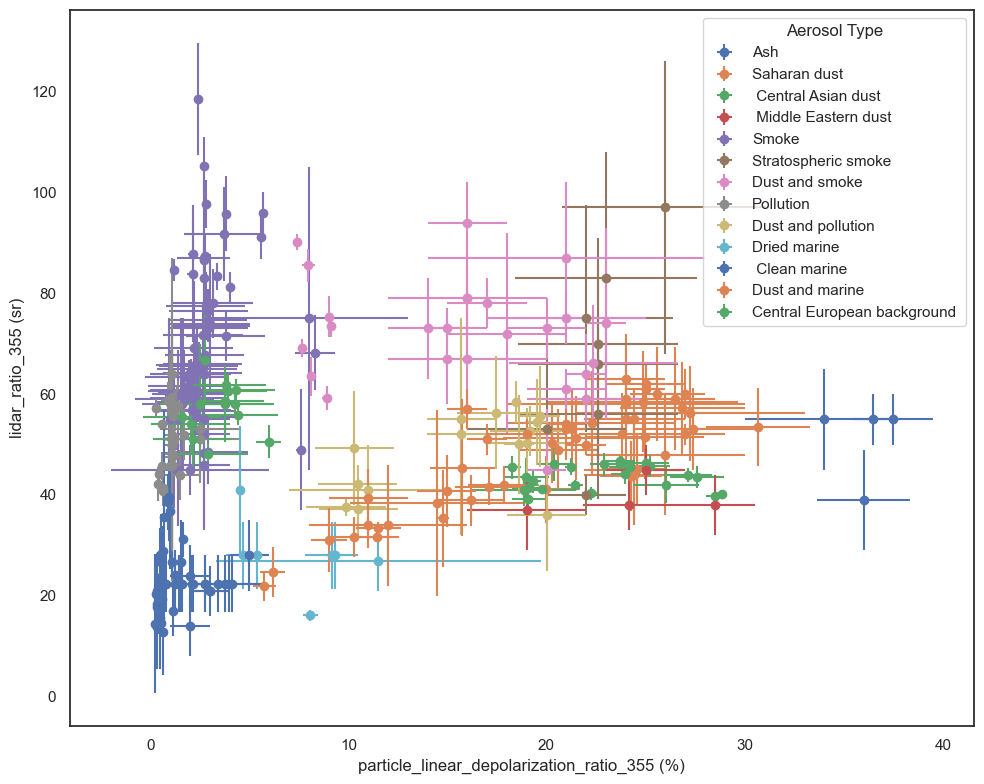

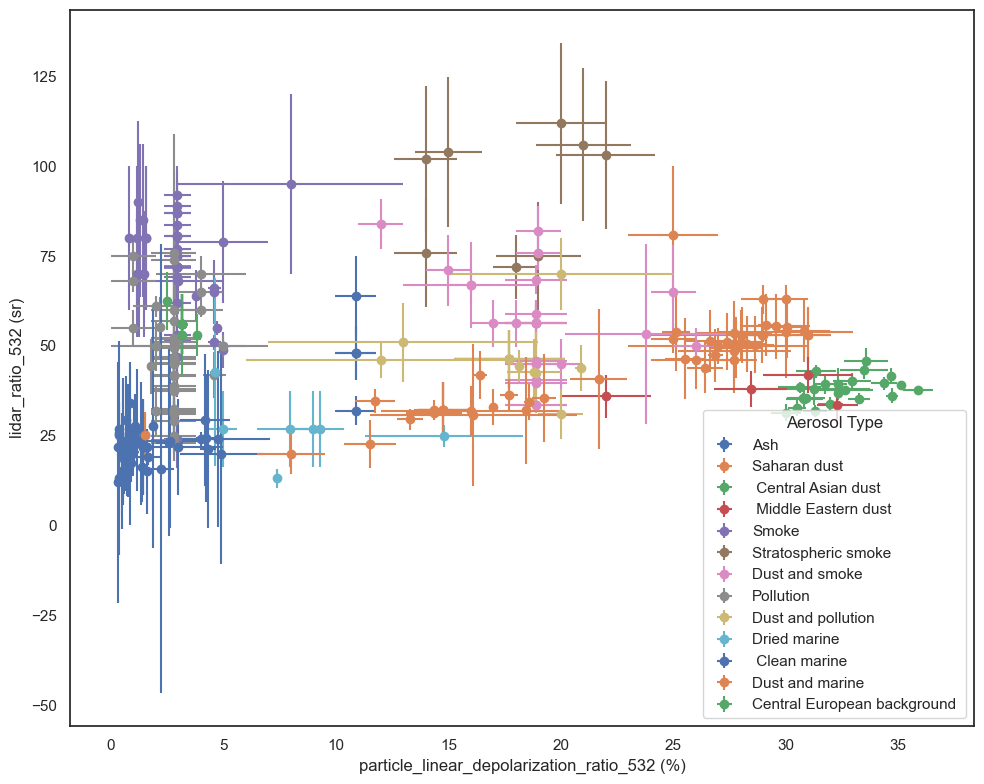

ValueError: 'xerr' must not contain negative values

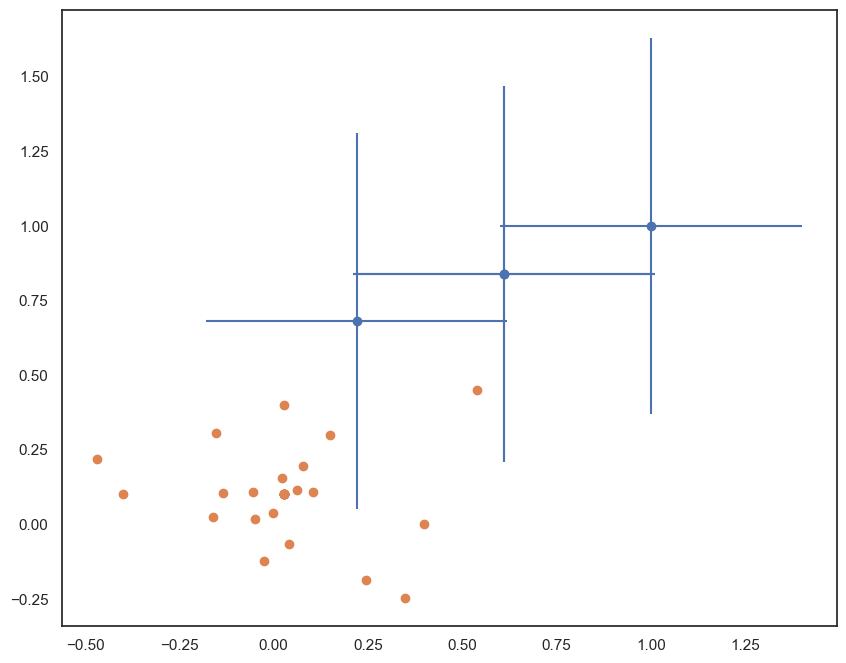

In [88]:


def visualize_with_error(df, x, y):
    plt.figure(figsize=(10, 8))
    sns.set_style("white")
    for aerosol_type in delian_df['aerosol'].unique():
        subset = df[delian_df['aerosol'] == aerosol_type]
        plt.errorbar(subset[x], subset[y],
                    xerr=subset['error_'+x], yerr=subset['error_'+y],
                    fmt = "o", label=aerosol_type)
    
    plt.legend(title='Aerosol Type')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.tight_layout()
    plt.show()

visualize_with_error(df_imputed, 'particle_linear_depolarization_ratio_355 (%)', 'lidar_ratio_355 (sr)')
visualize_with_error(df_imputed, 'particle_linear_depolarization_ratio_532 (%)', 'lidar_ratio_532 (sr)')
visualize_with_error(df_imputed, 'angstrom_exponent_backscatter_355_532 (1)', 'angstrom_exponent_extinction_355_532 (1)')

### **Principal Componants Analysis** *làm xong thấy vô dụng vl, bỏ qua đi*

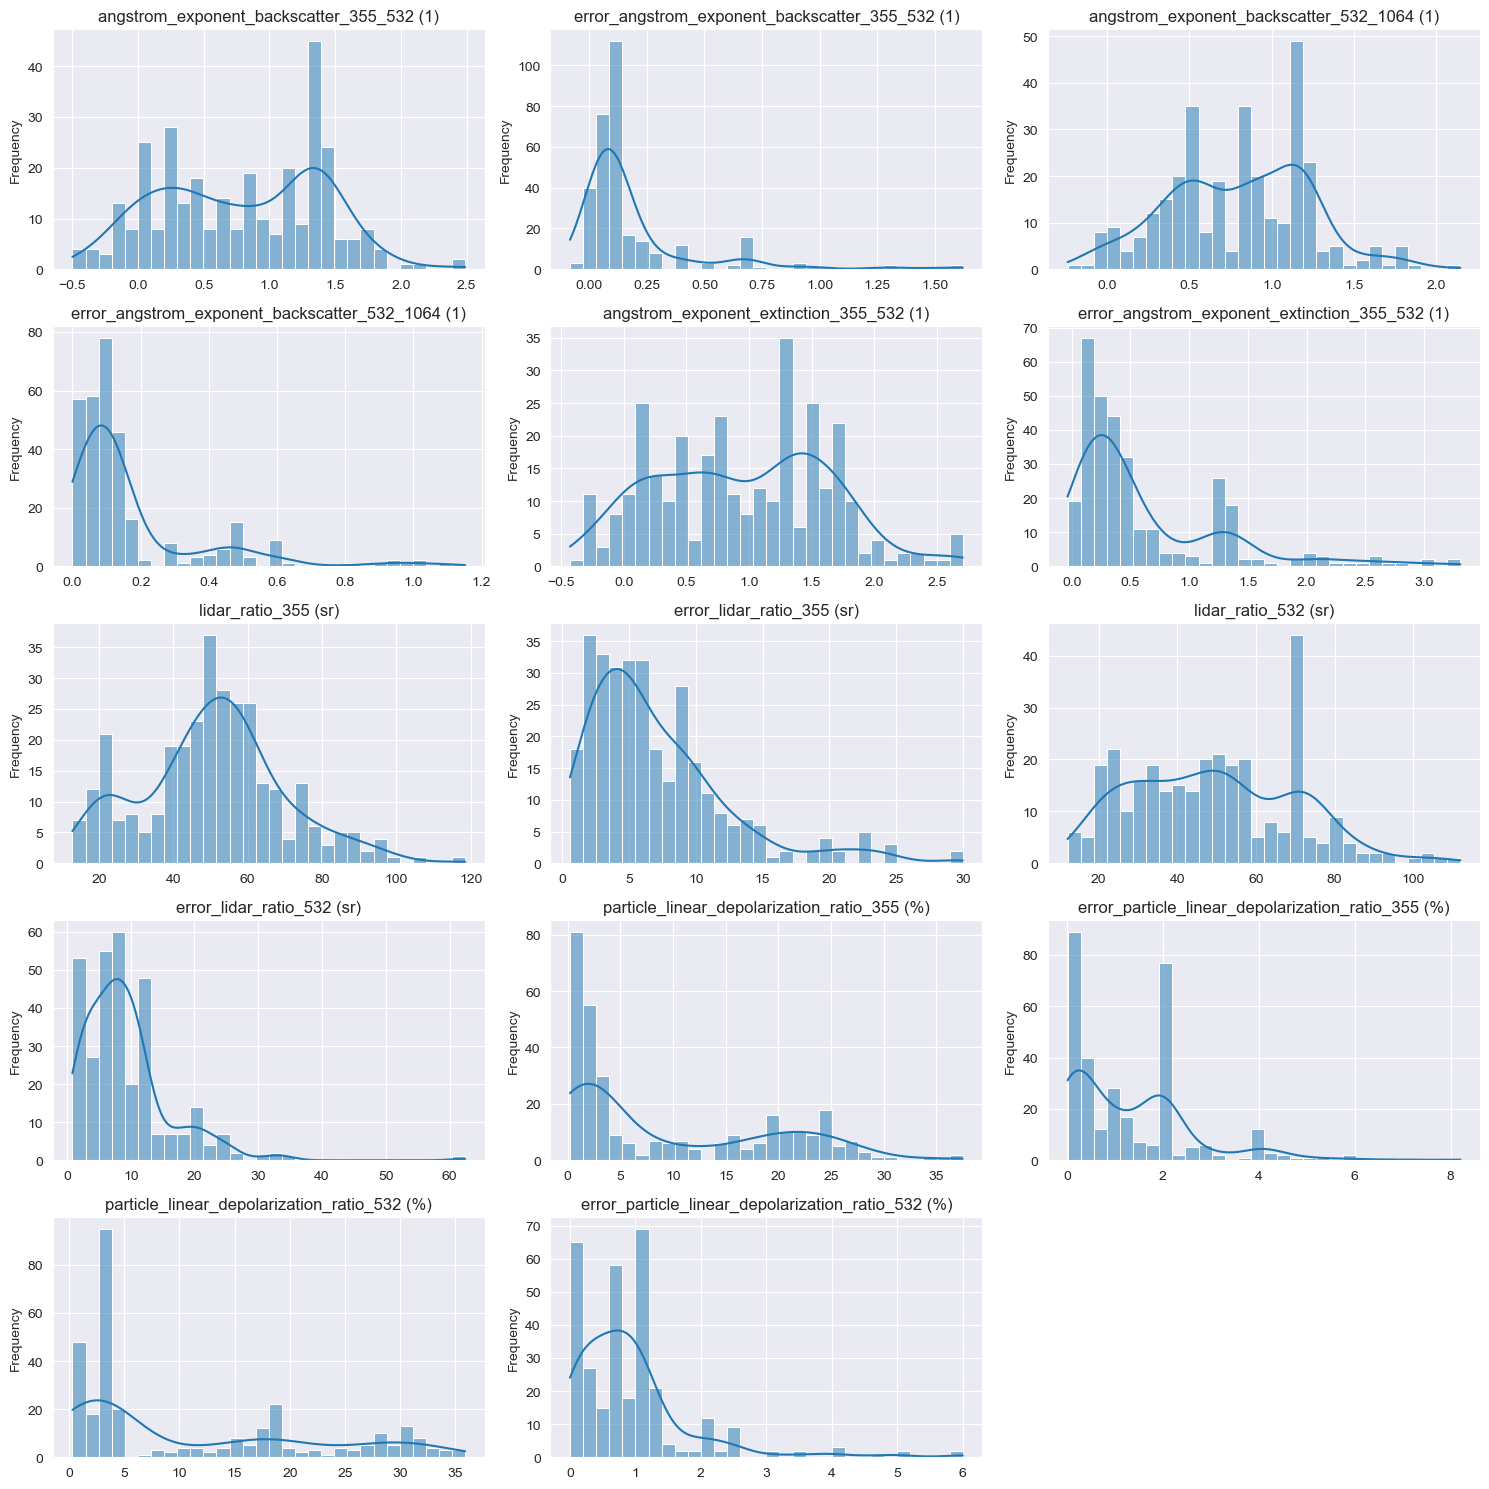

In [17]:
fig, axes = plt.subplots(5, 3, figsize=(15, 15))
axes = axes.flatten()

for i, column in enumerate(df_imputed.keys()):
    sns.histplot(data=df_imputed[column], bins = 30, kde=True, ax=axes[i])  # Create histogram plot
    axes[i].set_title(f'{column}')  # Set title for the plot
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlabel(None)

# Adjust layoutcolumns)
axes[-1].set_visible(False)
plt.tight_layout()
plt.show()

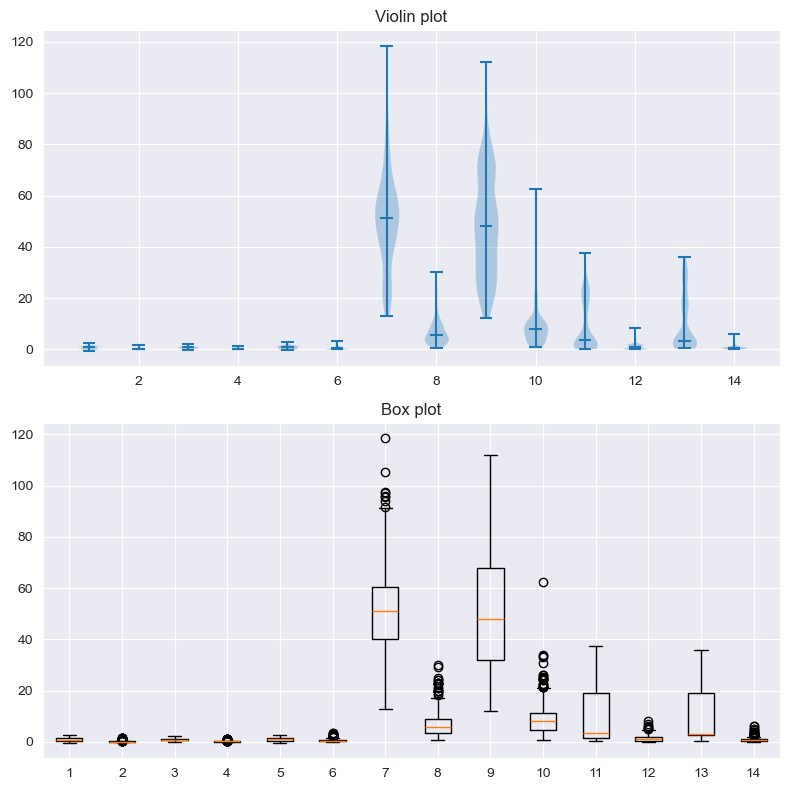

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

# violin plot
axs[0].violinplot(df_imputed, showmeans=False, showmedians=True)
axs[0].set_title('Violin plot')

# box plot
axs[1].boxplot(df_imputed)
axs[1].set_title('Box plot')

plt.tight_layout()
plt.show()

In [19]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
ss = StandardScaler()

# Fit and transform the data
df_scaled = ss.fit_transform(df_imputed)

# Convert the scaled data back to a DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

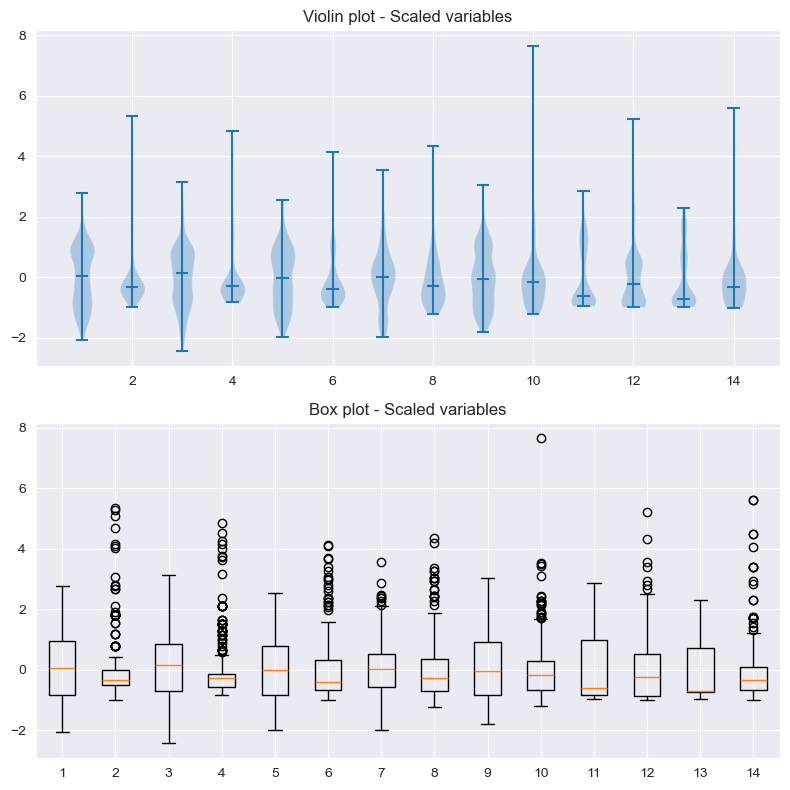

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

# violin plot
axs[0].violinplot(df_scaled, showmeans=False, showmedians=True)
axs[0].set_title('Violin plot - Scaled variables')

# box plot
axs[1].boxplot(df_scaled)
axs[1].set_title('Box plot - Scaled variables')

plt.tight_layout()
plt.show()

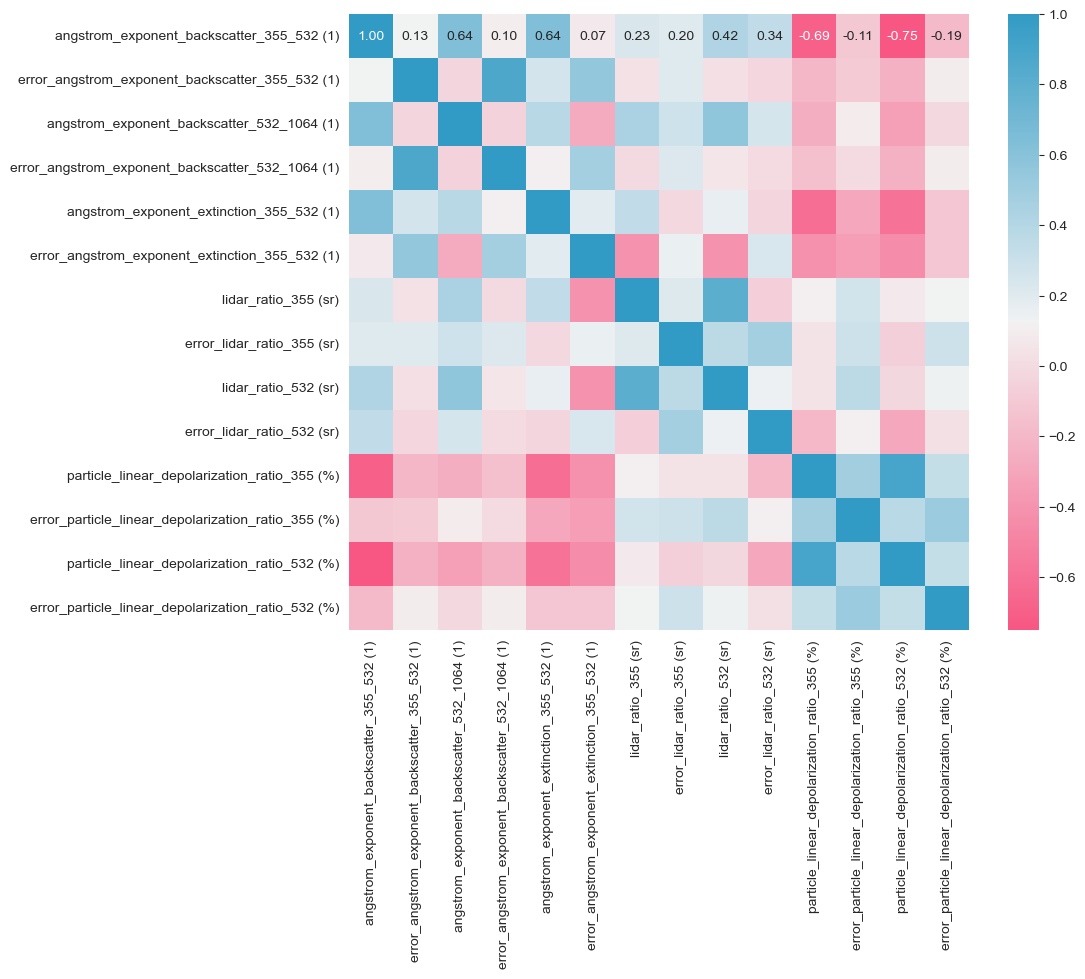

In [21]:
plt.figure(figsize=(10,8))
# correlation between columns
sns.heatmap(df_scaled.corr(), annot=True, fmt='.2f', cmap=cmap)
plt.xticks(rotation=90)

plt.show()

In [22]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA()
df_pca = pca.fit_transform(df_imputed)

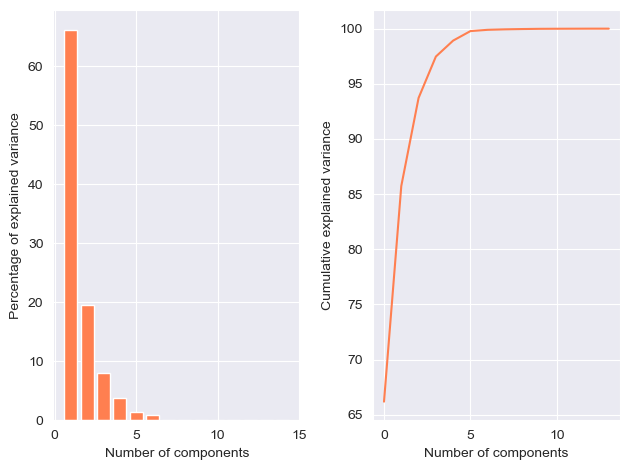

In [23]:
explained_variance_ratio = 100*pca.explained_variance_ratio_

plt.subplot(1,2,1)
n_bars = 14
plt.bar(np.arange(1, n_bars+1), explained_variance_ratio[:n_bars], color='coral')
plt.xlabel("Number of components")
plt.ylabel("Percentage of explained variance")

plt.subplot(1,2,2)
plt.plot(np.cumsum(explained_variance_ratio), color='coral')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

plt.tight_layout()
plt.show()

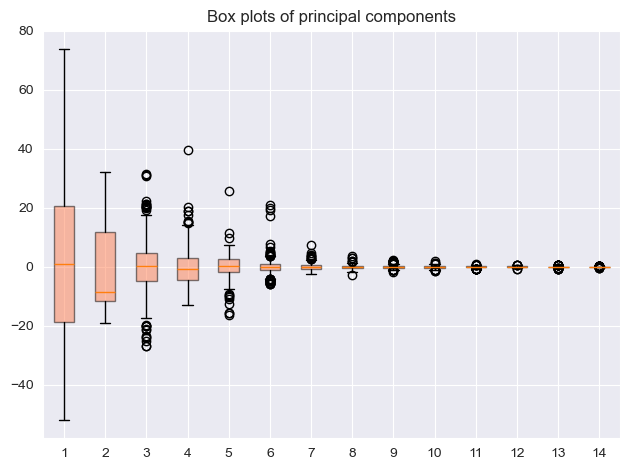

In [24]:
box = plt.boxplot(df_pca, patch_artist=True)
plt.setp(box["boxes"], facecolor="coral", alpha=.5)
plt.title("Box plots of principal components")
plt.tight_layout()
plt.show()

### **Data Preprocessing 2**

In [25]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

aerosol_encoder = label_encoder.fit_transform(aerosol.values.flatten())

aerosol_encoder

array([ 3,  3,  3,  3, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  2,  2,  2,  2, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12,
       12, 12, 12, 12,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  5,  5,  5,  5

Chia tập dữ liệu một cách có kiểm soát để đảm bảo tỷ lệ giữa tập huấn luyện và tập kiểm tra là nhất quán cho mỗi lớp.

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_imputed, aerosol_encoder, test_size=0.25, stratify=aerosol_encoder, random_state=42)

In [27]:
ss.fit(X_train)
X_train = ss.transform(X_train)
# Giữ nguyên tham số chuẩn hóa cho bộ test
X_test = ss.transform(X_test)

### **K-Nearest Neighbors**

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

param_grid=[{"n_neighbors":list(range(1,15))}]

# cv=3 nghĩa là phương pháp kiểm định chéo 3 lớp được sử dụng để đánh giá mỗi cấu hình tham số.
# n_jobs=-1 nghĩa là sử dụng tất cả các lõi CPU có sẵn để tăng tốc quá trình tìm kiếm.
stratified_k_fold = StratifiedKFold(n_splits=3) # Sử dụng số lượng splits phù hợp với dữ liệu
knn=GridSearchCV(KNeighborsClassifier(),param_grid,cv=stratified_k_fold,n_jobs=-1, verbose =2)

#knnOpt sẽ là phiên bản tối ưu của kNN sau khi tìm kiếm.
knnOpt=knn.fit(X_train, y_train)

print("Best score = %f, Best parameter = %s" % (knnOpt.best_score_,knnOpt.best_params_))

Fitting 3 folds for each of 14 candidates, totalling 42 fits


Best score = 0.869198, Best parameter = {'n_neighbors': 1}


In [29]:
# Dự đoán trên tập kiểm tra
y_pred = knnOpt.predict(X_test)

In [30]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Đánh giá mô hình
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.9113924050632911
[[ 6  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  4  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  5  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 11  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0 17  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  1]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      1.00      1.00        13
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         3
           5       1.00      0.50      0.67         2
           6       1.00      0.80      0.89  

### **Support Vector Machine (SVM)**

In [31]:
from sklearn.svm import SVC

param=[{"C":[0.4,0.5,0.6,0.8,1,1.4]}]
svm= GridSearchCV(SVC(),param,cv=stratified_k_fold,n_jobs=-1, verbose=2)
svmOpt=svm.fit(X_train, y_train)
print("Best score = %f, Best parameter = %s" % (svmOpt.best_score_,svmOpt.best_params_))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score = 0.856540, Best parameter = {'C': 1.4}


In [32]:
y_pred = svmOpt.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.8987341772151899
[[ 6  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  1  0  0  0]
 [ 0  1  0  0  0  0  3  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  3  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  5  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 11  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0 17  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  1]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.93      1.00      0.96        13
           2       0.00      0.00      0.00         1
           3       0.50      1.00      0.67         1
           4       1.00      1.00      1.00         3
           5       1.00      0.50      0.67         2
           6       0.75      0.60      0.67  

### **Decision Tree**

In [33]:
from sklearn.tree import DecisionTreeClassifier

param=[{"max_depth": [1, 2, 4, 8, 16, 32, 64, None]}]

dtc = DecisionTreeClassifier(random_state=42)

tree= GridSearchCV(dtc,param,cv=stratified_k_fold,n_jobs=-1, verbose =2)
treeOpt=tree.fit(X_train, y_train)

print("Best score = %f, Best parameter = %s" % (treeOpt.best_score_,treeOpt.best_params_))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best score = 0.827004, Best parameter = {'max_depth': 16}


In [34]:
y_pred = treeOpt.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.8860759493670886
[[ 6  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  6  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 11  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  1  0  0  0  0  1  0 16  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.85      0.92        13
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         1
           4       0.75      1.00      0.86         3
           5       1.00      1.00      1.00         2
           6       1.00      0.60      0.75  

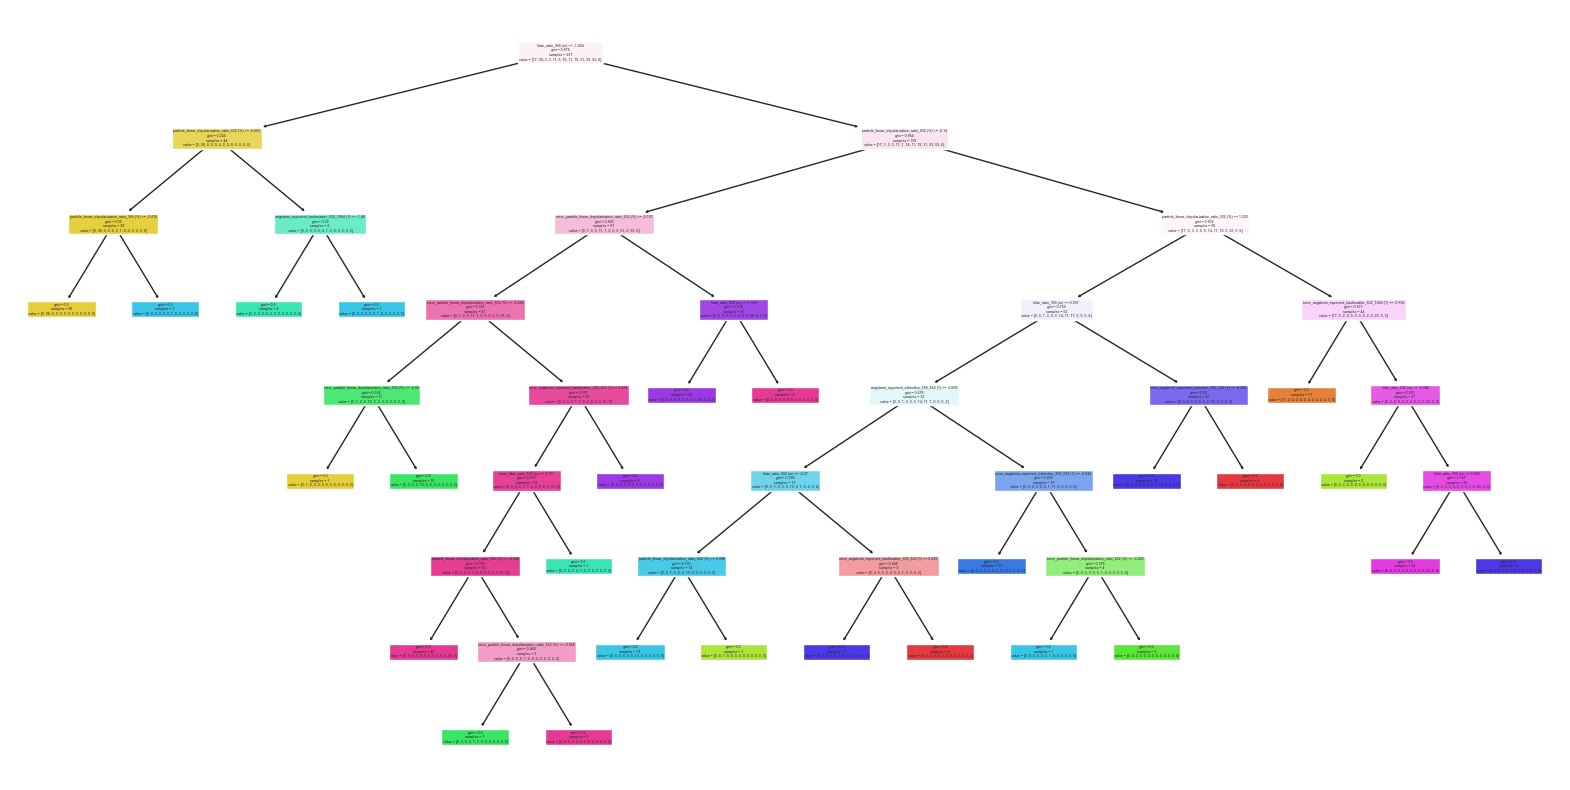

In [35]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10)) 
plot_tree(treeOpt.best_estimator_, filled = True, feature_names=df_imputed.columns.tolist())
plt.show() # đ thấy cc gì và cũng ko biết chỉnh sao

### **Random Forest**

In [36]:
from sklearn.ensemble import RandomForestClassifier

param=[{'n_estimators': [50, 100, 500],
        'max_features': [2, 3, 4],
        'max_depth' : [2, 4, 8, None]}]

rf= GridSearchCV(RandomForestClassifier(random_state=42),param,cv=stratified_k_fold,n_jobs=-1, verbose = 2)

rfOpt=rf.fit(X_train, y_train)

print("Best score = %f, Best parameter = %s" % (rfOpt.best_score_,rfOpt.best_params_))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best score = 0.936709, Best parameter = {'max_depth': 8, 'max_features': 2, 'n_estimators': 500}


In [37]:
y_pred = rfOpt.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.9367088607594937
[[ 6  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  3  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  5  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 11  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0 17  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.93      1.00      0.96        13
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         2
           6       1.00      0.60      0.75  

In [38]:
rf= rfOpt.best_estimator_

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print(df_imputed.columns[indices[f]], importances[indices[f]])

particle_linear_depolarization_ratio_532 (%) 0.11710431197201238
lidar_ratio_532 (sr) 0.11238954941092691
lidar_ratio_355 (sr) 0.11168695978188799
particle_linear_depolarization_ratio_355 (%) 0.09025526673049333
angstrom_exponent_extinction_355_532 (1) 0.07644710402696378
angstrom_exponent_backscatter_355_532 (1) 0.07553404928348288
error_particle_linear_depolarization_ratio_532 (%) 0.07016241983932987
error_angstrom_exponent_extinction_355_532 (1) 0.06376306324261574
error_angstrom_exponent_backscatter_532_1064 (1) 0.06366996655821239
error_angstrom_exponent_backscatter_355_532 (1) 0.057585856024099345
angstrom_exponent_backscatter_532_1064 (1) 0.0559575311823801
error_lidar_ratio_532 (sr) 0.036114515625889194
error_particle_linear_depolarization_ratio_355 (%) 0.035619416892453314
error_lidar_ratio_355 (sr) 0.0337099894292528


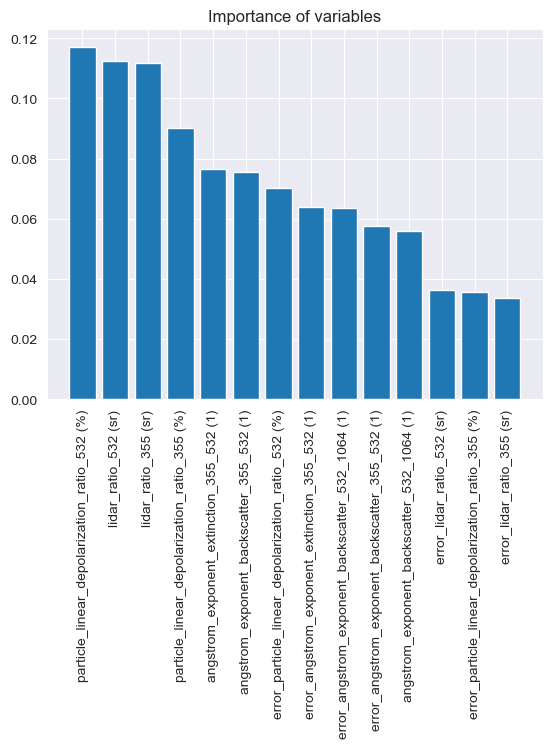

In [39]:
sorted_importances = [df_imputed.columns[indices[f]] for f in range(X_train.shape[1])]


plt.figure()
plt.title("Importance of variables")
plt.bar(range(X_train.shape[1]), importances[indices]);
plt.xticks(range(X_train.shape[1]), sorted_importances, rotation=90);
plt.show()

In [40]:
# Keeping NaN values
X_train, X_test, y_train, y_test = train_test_split(df, aerosol_encoder, test_size=0.25, stratify=aerosol_encoder, random_state=42)

In [41]:
ss.fit(X_train)
X_train = ss.transform(X_train)
# Giữ nguyên tham số chuẩn hóa cho bộ test
X_test = ss.transform(X_test)

### **Hist Gradient Boosting**

In [42]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier()

hgb.fit(X_train, y_train)

y_pred = hgb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.8987341772151899
[[ 6  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 12  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  2  2  0  0  0  0  0]
 [ 1  0  0  0  0  0  1  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  6  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 11  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0 17  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  2]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       0.92      0.92      0.92        13
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         2
           6       0.67      0.40      0.50  

### **Extreme Gradient Boosting (XGBoost)**

In [43]:
import xgboost as xgb
from xgboost import XGBClassifier

param = [{
    'n_estimators': [50, 100, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 4, 8, None]
}]

xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgbs = GridSearchCV(xgb_model, param, cv=stratified_k_fold, n_jobs=-1, verbose=2)

xgbOpt = xgbs.fit(X_train, y_train)

print("Best score = %f, Best parameter = %s" % (xgbOpt.best_score_,xgbOpt.best_params_))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best score = 0.911392, Best parameter = {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 500}


In [44]:
y_pred = xgbOpt.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.9240506329113924
[[ 6  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 12  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  3  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  3  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  6  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 11  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0 17  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.92      0.92      0.92        13
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         1
           4       0.75      1.00      0.86         3
           5       1.00      1.00      1.00         2
           6       1.00      0.60      0.75  